# Modified PyEnergyDiagrams

Original repository:
- https://github.com/giacomomarchioro/PyEnergyDiagrams

Forked repository:
- https://github.com/giacomomarchioro/PyEnergyDiagrams

## Google Drive のマウント（Google Colab の場合）
- My drive 直下の「Colab Notebook」フォルダ内で作業すること

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install cmocean
# Set your environment
import sys
%cd /content/drive/MyDrive/Colab Notebooks/plot_Figs_ReSPer_Colab
sys.path.append('/content/drive/MyDrive/Colab Notebooks/plot_Figs_ReSPer_Colab/parser_resper2matplotlib.py')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/plot_Figs_ReSPer_Colab/method_matplotlib_plotly.py')

# Reload modules
#    Ref: https://qiita.com/Kunikata/items/45e731753e97bda28aab
# import importlib
# importlib.reload(module1)

In [11]:
import sys
import pandas as pd
from pathlib import Path

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial setting

### csv データから必要なデータを読み込み、加工（前処理）

csv ファイルには少なくとも以下の列名が必要

**Energy, Color, Position, LineStyle, LineWidth, TopText, BottomText, RightText, LeftText, LinkTo, LinkLineStyle, LinkLineWidth, LinkLineColor**

- それぞれの列を energy, color のような変数に格納
- 必要に応じて欠損値（NaN）の処理や型変換を実施
  - df["Color"].fillna("black") は csv の Color 列が空白（NaN）であれば "black" で埋めるという意味
  - これによってデフォルト値を指定

### csv ファイルで利用可能な parameters

- Color
  - black, red, blue, green など。詳細 → https://matplotlib.org/stable/gallery/color/named_colors.html
- Position
  - エネルギー準位を描画する x 座標を指定。小数、負の値も指定可能。
- LineStyle
  - solid, dashed, dashdot, dotted のみ利用可能。
- LineWidth
  - エネルギー準位の太さを指定。デフォルトは 1.0（add_level 関数で処理）。
- TopText, BottomText, RightText, LeftText
  - エネルギー準位の上、下、右、左に挿入されるテキスト。
- LinkTo
  - エネルギー準位を結ぶ link の行き先の行番号を指定。0 から始まる行番号で指定する。
  - 出発点は自分自身の行番号となる。
- LinkLineStyle
  - link の LineStyle。LineStyle と同様。
- LinkLineWidth
  - link の LineWidth。LineWidth と同様。
- LinkLineColor
  - link の LineColor。LineColor と同様。

In [56]:
INPUT_DIR = "INPUT"
CSV_FNAME = "test.csv"

FIGSIZE = (5, 10)
FONTSIZE = 18

df = pd.read_csv(INPUT_DIR + "/" + CSV_FNAME, index_col=0)

# For energy diagram
energy = df["Energy"].fillna(0.0)
color = df["Color"].fillna("black")
position = df["Position"].fillna(0)
linestyle = df["LineStyle"].fillna("solid")
linewidth = df["LineWidth"].fillna(-9999)
toptxt = df["TopText"].fillna("")  # See https://qiita.com/0NE_shoT_/items/8db6d909e8b48adcb203#fillna
bottxt = df["BottomText"].fillna("")
rigtxt = df["RightText"].fillna("")
leftxt = df["LeftText"].fillna("")

# For linkage
df_link = df.filter(like="Link", axis=1)  # Get LinkXXX columns
df_link = df_link.dropna(how="any")  # Delete row with NaN. See https://qiita.com/0NE_shoT_/items/8db6d909e8b48adcb203#dropna
linkfrom = df.index.astype(int)
linkto = df_link["LinkTo"].astype(int)
linklinestyle = df_link["LinkLineStyle"].fillna("dashed")
linklinewidth = df_link["LinkLineWidth"].fillna(1.0)
linklinecolor = df_link["LinkLineColor"].fillna("black")

df

,Name,Energy,Color,Position,LineStyle,LineWidth,TopText,BottomText,RightText,LeftText,LinkTo,LinkLineStyle,LinkLineWidth,LinkLineColor
0,T1 A',0,k,0.0,solid,2,T1 A',bottom,0.0,NaN,NaN,NaN,NaN,NaN
1,T1 A',1,k,0.0,solid,2,T2 A'',NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,T2 A'',5,red,0.5,dashed,2,S1 A',1⊿,5.0,NaN,NaN,NaN,NaN,NaN
3,T3 A''',5,blue,-0.5,dashdot,2,S2 A',1⊿,5.0,NaN,NaN,NaN,NaN,NaN
4,T4 A'''',10,k,0.0,dotted,2,T3 A',NaN,10.0,NaN,NaN,NaN,NaN,NaN
5,Exp,8,green,-1.0,solid,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Exp,8,green,-0.5,dashed,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Exp,8,green,0.0,solid,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Exp,8,green,0.5,dashed,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Exp,8,green,1.0,dotted,2,Exp,NaN,8.0,NaN,NaN,NaN,NaN,NaN


## PyEnergyDiagrams

### エネルギーダイアグラムを作成

- diagram = ED()
  - PyEnergyDiagrams プログラムに実装されている ED クラスを diagram として利用
- First loop
  - エネルギー準位 (level) を描画するための情報を指定
- Second loop
  - エネルギー準位を結ぶ直線 (link) を描画するための情報を指定
- diagram.plot()
  - First, second loops で指定した情報を元にエネルギーダイアグラムを描画


<Figure size 432x288 with 0 Axes>

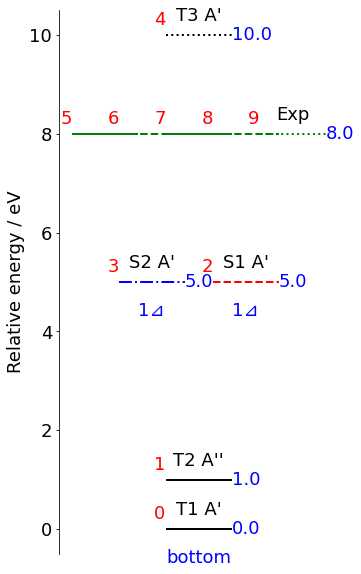

In [57]:
%autoreload 2
sys.path.append(str(Path().resolve().parent) + "/energydiagram/")
from energydiagram import ED

diagram = ED()

# For levels
for iene, ic, ipos, ils, ilw, itoptxt, ibottex, irigtxt, ileftex in zip(energy, color, position, linestyle, linewidth, toptxt, bottxt, rigtxt, leftxt):
    diagram.add_level(energy=iene, bottom_text=ibottex, position=ipos, color=ic, top_text=itoptxt, right_text=irigtxt, left_text=ileftex, linestyle=ils, linewidth=ilw)

# For links
for ifrom, ito, ils, ilw, ic in zip(linkfrom, linkto, linklinestyle, linklinewidth, linklinecolor):
    diagram.add_link(start_level_id=ifrom, end_level_id=ito, color=ic, ls=ils, linewidth=ilw)

diagram.plot(show_IDs=True, figsize=FIGSIZE, fontsize=FONTSIZE, ylabel="Relative energy / eV")

# Save plots
outfname = "%s_EnergyDiagram" % str(Path(CSV_FNAME).stem)
diagram.fig.savefig(outfname + ".png", dpi=400, transparent=True, bbox_inches='tight')
diagram.fig.savefig(outfname + ".svg", dpi=400, transparent=True, bbox_inches='tight')  # ベクター画像。拡大しても画質が変わらない。
# diagram.fig.savefig(outfname + ".eps", dpi=400, transparent=True, bbox_inches='tight')  # ベクター画像。PPTに貼り付けられるかも？